# Multi-Output SCA Demo

This notebook demonstrates the Side-Channel Attack using a pre-trained multi-output neural network.

**What this demo does:**
1. Loads a pre-trained model from `checkpoints/`
2. Runs the attack on a sample of traces from the ASCAD dataset
3. Displays the key recovery results
4. Saves output plots and summary to `results/`

**Prerequisites:**
- Pre-trained model in `checkpoints/multi_output_sca.pt`
- ASCAD dataset in `datasets/ASCADv1/ASCAD.h5`


In [ ]:
# Setup: imports and configuration
import os
import sys

# Add project root to path for imports
PROJECT_ROOT = os.getcwd()
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import torch
import numpy as np
import matplotlib.pyplot as plt

# Import from src
from src.config import (
    CHECKPOINT_DIR, MODEL_FILENAME, FILE_PATH, 
    TARGET_BYTE_IDX, BATCH_SIZE
)
from src.model import load_model
from src.utils import (
    load_ascad_attack, normalize_traces, 
    generate_labels, compute_key_scores, rank_keys
)

# Demo-specific configuration
DEMO_NUM_TRACES = 1000  # Number of attack traces to use
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Project root: {PROJECT_ROOT}")


## 1. Load Pre-trained Model


In [ ]:
# Load the pre-trained model
model_path = os.path.join('..', CHECKPOINT_DIR, MODEL_FILENAME)

if not os.path.exists(model_path):
    raise FileNotFoundError(
        f"Model not found at {model_path}. "
        "Please run the training notebook (mlpmp_SCA.ipynb) first to generate the model."
    )

model, config, metadata = load_model(model_path, device=device)

print("\n--- Training Configuration ---")
for key, value in config.items():
    print(f"  {key}: {value}")

print("\n--- Training Results ---")
for key, value in metadata.items():
    print(f"  {key}: {value}")


## 2. Load Attack Traces

We use attack traces (separate from training data) to demonstrate the key recovery.


In [ ]:
# Load attack traces from the ASCAD dataset
file_path = os.path.join('..', FILE_PATH)

traces, plaintexts, real_key = load_ascad_attack(
    file_path,
    num_traces=DEMO_NUM_TRACES,
    start_idx=0,
    target_byte=TARGET_BYTE_IDX
)

# Normalize and convert to tensor
traces_tensor = normalize_traces(traces)
labels_tensor = generate_labels(plaintexts)

print(f"Loaded {DEMO_NUM_TRACES} attack traces")
print(f"Traces shape: {traces_tensor.shape}")
print(f"Real key byte: {hex(real_key)}")


Loaded 1000 attack traces
Traces shape: torch.Size([1000, 700])
Real key byte: 0xe0


## 3. Run Attack

Compute key scores using the pre-trained model and rank the key candidates.


In [ ]:
# Compute key scores
key_scores = compute_key_scores(
    model, 
    traces_tensor, 
    labels_tensor, 
    device=device, 
    batch_size=BATCH_SIZE
)

# Rank keys
sorted_keys, rank_of_real = rank_keys(key_scores, real_key)

# Get top candidates
top_5_keys = sorted_keys[:5]
top_5_scores = key_scores[top_5_keys]

print("=" * 50)
print("ATTACK RESULTS")
print("=" * 50)
print(f"Real Key Byte:     {hex(real_key)}")
print(f"Real Key Rank:     {rank_of_real}")
print(f"Real Key Score:    {key_scores[real_key]:.4f}")
print()
print("Top 5 Key Candidates:")
for i, (k, s) in enumerate(zip(top_5_keys, top_5_scores)):
    marker = " <-- REAL KEY" if k == real_key else ""
    print(f"  {i+1}. {hex(k)} (score: {s:.4f}){marker}")
print("=" * 50)

if rank_of_real == 1:
    print("\n✓ KEY RECOVERED SUCCESSFULLY!")
else:
    print(f"\n✗ Key not recovered (rank {rank_of_real})")


ATTACK RESULTS
Real Key Byte:     0xe0
Real Key Rank:     1
Real Key Score:    -0.6924

Top 5 Key Candidates:
  1. 0xe0 (score: -0.6924) <-- REAL KEY
  2. 0x98 (score: -0.7168)
  3. 0xb2 (score: -0.7189)
  4. 0xa0 (score: -0.7208)
  5. 0x34 (score: -0.7211)

✓ KEY RECOVERED SUCCESSFULLY!


## 4. Visualize Results

Generate plots showing the key score distribution.


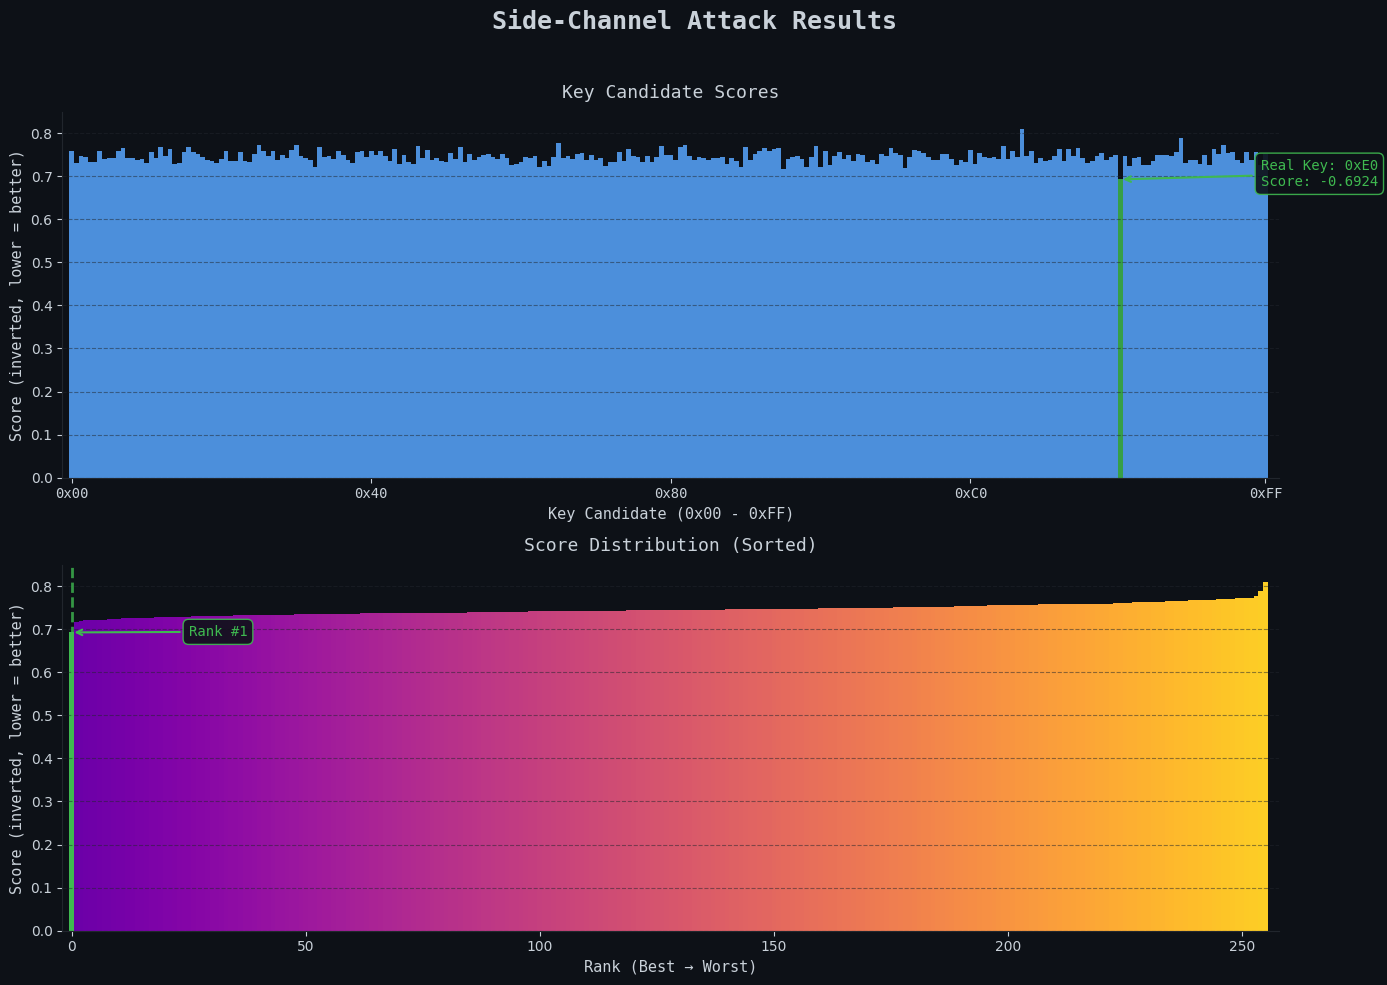


✓ Plot saved to results/ key_scores.png


In [ ]:
# Create visualization figures with a distinctive aesthetic
plt.style.use('dark_background')

# Color palette - cyberpunk inspired for crypto/security theme
BG_COLOR = '#0d1117'
GRID_COLOR = '#21262d'
ACCENT_1 = '#58a6ff'  # Bright blue for highlights
ACCENT_2 = '#f78166'  # Coral for contrast
TEXT_COLOR = '#c9d1d9'
REAL_KEY_COLOR = '#3fb950'  # Green for success

# Invert scores: negate so lower (more negative) original scores appear as taller bars
# This makes "better candidates" (higher original scores) appear as shorter bars
inverted_scores = -key_scores

fig = plt.figure(figsize=(14, 10), facecolor=BG_COLOR)
fig.suptitle('Side-Channel Attack Results', fontsize=18, fontweight='bold', 
             color=TEXT_COLOR, fontfamily='monospace', y=0.98)

# --- Plot 1: Key Scores Bar Chart (All 256 Candidates) ---
ax1 = fig.add_subplot(2, 1, 1, facecolor=BG_COLOR)

# Create colors array - highlight real key
colors = [ACCENT_1 if i != real_key else REAL_KEY_COLOR for i in range(256)]
bars = ax1.bar(range(256), inverted_scores, color=colors, alpha=0.85, width=1.0, edgecolor='none')

# Highlight real key with annotation
ax1.annotate(
    f'Real Key: 0x{real_key:02X}\nScore: {key_scores[real_key]:.4f}',
    xy=(real_key, inverted_scores[real_key]),
    xytext=(real_key + 30, inverted_scores[real_key] - 0.015),
    fontsize=10, color=REAL_KEY_COLOR, fontfamily='monospace',
    arrowprops=dict(arrowstyle='->', color=REAL_KEY_COLOR, lw=1.5),
    bbox=dict(boxstyle='round,pad=0.4', facecolor=BG_COLOR, edgecolor=REAL_KEY_COLOR, alpha=0.9)
)

ax1.set_xlabel('Key Candidate (0x00 - 0xFF)', fontsize=11, color=TEXT_COLOR, fontfamily='monospace')
ax1.set_ylabel('Score (inverted, lower = better)', fontsize=11, color=TEXT_COLOR, fontfamily='monospace')
ax1.set_title('Key Candidate Scores', fontsize=13, color=TEXT_COLOR, fontfamily='monospace', pad=10)
ax1.set_xlim(-2, 258)
ax1.tick_params(colors=TEXT_COLOR)
ax1.spines['bottom'].set_color(GRID_COLOR)
ax1.spines['left'].set_color(GRID_COLOR)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', color=GRID_COLOR, linestyle='--', alpha=0.5)

# Add hex tick labels at key positions
hex_ticks = [0, 64, 128, 192, 255]
ax1.set_xticks(hex_ticks)
ax1.set_xticklabels([f'0x{t:02X}' for t in hex_ticks], fontfamily='monospace')

# --- Plot 2: Sorted Score Distribution ---
ax2 = fig.add_subplot(2, 1, 2, facecolor=BG_COLOR)

# Sort by original scores (best = highest), then plot inverted
sorted_indices = np.argsort(key_scores)[::-1]  # Descending (best = highest original)
sorted_inverted = inverted_scores[sorted_indices]
real_key_position = np.where(sorted_indices == real_key)[0][0]

# Create gradient colors for sorted bars
gradient_colors = plt.cm.plasma(np.linspace(0.2, 0.9, 256))
gradient_colors[real_key_position] = plt.matplotlib.colors.to_rgba(REAL_KEY_COLOR)

ax2.bar(range(256), sorted_inverted, color=gradient_colors, width=1.0, edgecolor='none')

# Mark real key position with vertical line and annotation
ax2.axvline(x=real_key_position, color=REAL_KEY_COLOR, linestyle='--', linewidth=2, alpha=0.8)
ax2.annotate(
    f'Rank #{real_key_position + 1}',
    xy=(real_key_position, sorted_inverted[real_key_position]),
    xytext=(real_key_position + 25, sorted_inverted[real_key_position] - 0.008),
    fontsize=10, color=REAL_KEY_COLOR, fontfamily='monospace',
    arrowprops=dict(arrowstyle='->', color=REAL_KEY_COLOR, lw=1.5),
    bbox=dict(boxstyle='round,pad=0.4', facecolor=BG_COLOR, edgecolor=REAL_KEY_COLOR, alpha=0.9)
)

ax2.set_xlabel('Rank (Best → Worst)', fontsize=11, color=TEXT_COLOR, fontfamily='monospace')
ax2.set_ylabel('Score (inverted, lower = better)', fontsize=11, color=TEXT_COLOR, fontfamily='monospace')
ax2.set_title('Score Distribution (Sorted)', fontsize=13, color=TEXT_COLOR, fontfamily='monospace', pad=10)
ax2.set_xlim(-2, 258)
ax2.tick_params(colors=TEXT_COLOR)
ax2.spines['bottom'].set_color(GRID_COLOR)
ax2.spines['left'].set_color(GRID_COLOR)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='y', color=GRID_COLOR, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(RESULTS_DIR, 'key_scores.png'), dpi=150, facecolor=BG_COLOR, edgecolor='none')
plt.show()

print(f"\n✓ Plot saved to results/ {'key_scores.png'}")


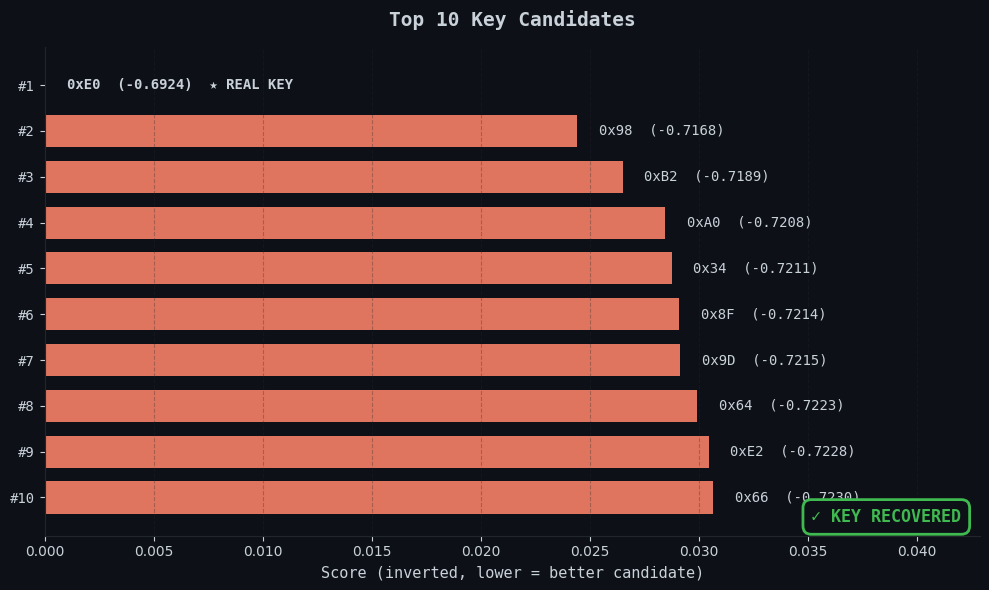

✓ Plot saved to results/ top_candidates.png


In [ ]:
# Second plot: Top Key Candidates Horizontal Bar Chart
fig2, ax = plt.subplots(figsize=(10, 6), facecolor=BG_COLOR)
ax.set_facecolor(BG_COLOR)

# Get top 10 candidates for detailed view
top_n = 10
top_n_keys = sorted_keys[:top_n]
top_n_scores = key_scores[top_n_keys]

# Invert: use negated scores so lower original scores appear as longer bars
top_n_inverted = inverted_scores[top_n_keys]
# Shift to start from 0 for bar length
bar_lengths = top_n_inverted - top_n_inverted.min()

# Create horizontal bars with colors
bar_colors = [REAL_KEY_COLOR if k == real_key else ACCENT_2 for k in top_n_keys]
y_pos = np.arange(top_n)[::-1]  # Reverse so rank 1 is at top

bars = ax.barh(y_pos, bar_lengths, color=bar_colors, alpha=0.9, height=0.7, edgecolor='none')

# Add labels on bars
for i, (bar, k, s) in enumerate(zip(bars, top_n_keys, top_n_scores)):
    width = bar.get_width()
    label = f'0x{k:02X}  ({s:.4f})'
    if k == real_key:
        label += '  ★ REAL KEY'
    ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, label,
            va='center', ha='left', fontsize=10, color=TEXT_COLOR, fontfamily='monospace',
            fontweight='bold' if k == real_key else 'normal')

# Style
ax.set_yticks(y_pos)
ax.set_yticklabels([f'#{i+1}' for i in range(top_n)], fontfamily='monospace', color=TEXT_COLOR)
ax.set_xlabel('Score (inverted, lower = better candidate)', fontsize=11, color=TEXT_COLOR, fontfamily='monospace')
ax.set_title('Top 10 Key Candidates', fontsize=14, color=TEXT_COLOR, fontfamily='monospace', pad=15, fontweight='bold')

ax.tick_params(colors=TEXT_COLOR)
ax.spines['bottom'].set_color(GRID_COLOR)
ax.spines['left'].set_color(GRID_COLOR)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, bar_lengths.max() * 1.4)

# Add subtle grid
ax.grid(axis='x', color=GRID_COLOR, linestyle='--', alpha=0.3)

# Add decorative success indicator
if rank_of_real == 1:
    ax.text(0.98, 0.02, '✓ KEY RECOVERED', transform=ax.transAxes,
            fontsize=12, color=REAL_KEY_COLOR, fontfamily='monospace', fontweight='bold',
            ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', facecolor=BG_COLOR, edgecolor=REAL_KEY_COLOR, linewidth=2))

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'top_candidates.png'), dpi=150, facecolor=BG_COLOR, edgecolor='none')
plt.show()

print(f"✓ Plot saved to results/ {'top_candidates.png'}")


## 5. Save Summary

Save a text summary of the attack results.


In [ ]:
# Save attack summary to text file
summary_path = os.path.join(RESULTS_DIR, 'attack_summary.txt')

with open(summary_path, 'w') as f:
    f.write("=" * 50 + "\n")
    f.write("MULTI-OUTPUT SCA ATTACK SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    
    f.write("--- Model Configuration ---\n")
    for key, value in config.items():
        f.write(f"  {key}: {value}\n")
    f.write("\n")
    
    f.write("--- Attack Parameters ---\n")
    f.write(f"  Number of traces: {DEMO_NUM_TRACES}\n")
    f.write(f"  Target byte index: {TARGET_BYTE_IDX}\n")
    f.write("\n")
    
    f.write("--- Results ---\n")
    f.write(f"  Real Key Byte: {hex(real_key)}\n")
    f.write(f"  Real Key Rank: {rank_of_real}\n")
    f.write(f"  Real Key Score: {key_scores[real_key]:.4f}\n")
    f.write(f"  Key Recovered: {'Yes' if rank_of_real == 1 else 'No'}\n")
    f.write("\n")
    
    f.write("--- Top 5 Key Candidates ---\n")
    for i, (k, s) in enumerate(zip(top_5_keys, top_5_scores)):
        marker = " <-- REAL KEY" if k == real_key else ""
        f.write(f"  {i+1}. {hex(k)} (score: {s:.4f}){marker}\n")
    
    f.write("\n" + "=" * 50 + "\n")

print(f"Summary saved to: {summary_path}")
print("\n--- Demo Complete ---")
print(f"Results saved to: {RESULTS_DIR}/")
